# Monthly Fracture Maps

Next, we will pair the stress maps with a monthly time series of fracture maps, courtesy of Trystan Surawy-Stepney.

## Import Packages

In [1]:
import geopandas as gpd
import numpy as np
import xarray as xr
import rioxarray as rxr

from shapely.geometry import Polygon
from shapely.geometry import Point
import matplotlib.pyplot as plt

import json
import blue_ice_tools as bit
import itslivetools

%env PYTHONWARNINGS=ignore

env: PYTHONWARNINGS=ignore


## Load in Shapefile, Velocity Data, and compute Stress

In [2]:
# Read in shapefile of Shirase Glacier
shirase_shape = gpd.read_file('../data/shirase-glacier/shirase.shp')

# Load in ITS_LIVE velocities with shape
shirase_stress = bit.get_data_cube(shape=shirase_shape, epsg=3031)

# Create a list of variable names
vars = ['eps_eff', 'eps_xx', 'eps_yy', 'sigma_vm', 'sigma1', 'sigma2']

# Call stress function, save outputs as new data vars
shirase_stress[vars] = bit.compute_strain_stress(shirase_stress.vx, shirase_stress.vy, rotate=True)
shirase_stress

<xarray.Dataset> Size: 750MB
Dimensions:      (mid_date: 97, y: 655, x: 328)
Coordinates:
  * x            (x) float64 3kB 1.344e+06 1.344e+06 ... 1.383e+06 1.384e+06
  * y            (y) float64 5kB 1.649e+06 1.65e+06 ... 1.728e+06 1.728e+06
    spatial_ref  int64 8B 0
    mapping      int64 8B 0
  * mid_date     (mid_date) datetime64[ns] 776B 2015-01-31 ... 2023-01-31
Data variables:
    v            (mid_date, y, x) float32 83MB dask.array<chunksize=(97, 655, 328), meta=np.ndarray>
    vx           (mid_date, y, x) float32 83MB dask.array<chunksize=(97, 655, 328), meta=np.ndarray>
    vy           (mid_date, y, x) float32 83MB dask.array<chunksize=(97, 655, 328), meta=np.ndarray>
    eps_eff      (mid_date, y, x) float32 83MB dask.array<chunksize=(97, 655, 328), meta=np.ndarray>
    eps_xx       (mid_date, y, x) float32 83MB dask.array<chunksize=(97, 655, 328), meta=np.ndarray>
    eps_yy       (mid_date, y, x) float32 83MB dask.array<chunksize=(97, 655, 328), meta=np.ndarray>
    sigma_vm     (mid_date, y, x) float32 83MB dask.array<chunksize=(97, 655, 328), meta=np.ndarray>
    sigma1       (mid_date, y, x) float32 83MB dask.array<chunksize=(97, 655, 328), meta=np.ndarray>
    sigma2       (mid_date, y, x) float32 83MB dask.array<chunksize=(97, 655, 328), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               26-Sep-2023 13:16:09
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/S70E030/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/S70E030/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

## Load in Fracture Maps

Thank you Trys for providing monthly crevasse maps that have a considerable overlap, from July 2018 - January 2023

In [3]:
fracture = xr.open_dataset('../data/shirase-glacier/shirase-fracture-clipped.nc')
fracture

<xarray.Dataset> Size: 93MB
Dimensions:        (mid_date: 54, y: 655, x: 328)
Coordinates:
  * mid_date       (mid_date) datetime64[ns] 432B 2018-07-31 ... 2023-01-31
    spatial_ref    int64 8B ...
  * x              (x) float64 3kB 1.344e+06 1.344e+06 ... 1.383e+06 1.384e+06
  * y              (y) float64 5kB 1.649e+06 1.65e+06 ... 1.728e+06 1.728e+06
    mapping        int64 8B ...
Data variables:
    fracture_conf  (mid_date, y, x) float64 93MB ...

Let's take a quick look at one of these composites

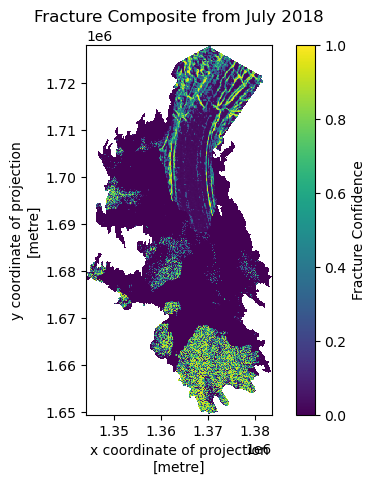

In [4]:
fig, ax = plt.subplots()

fracture.fracture_conf[0].plot(ax=ax, vmax=1, cbar_kwargs={'label':'Fracture Confidence'})
ax.set_title('Fracture Composite from July 2018')
ax.set_aspect('equal')
plt.show()

These composites cover the entire area of Shirase Glacier. They have significantly higher resolution on floating ice. Now, let's merge them with the ITS_LIVE velocity data. <br>
The fracture dataset has dates ranging from July 2018-January 2023. We'll need to clip the velocity dataset to match this range before we merge them. 

Since the two datasets have the exact same time dimensions, we can use `xr.merge`. If they were different, we would have to use `xr.concat` and specify that we want to merge along `dim='mid_date'`

In [ ]:
# Select the slice of dates that are covered by the fracture dataset
shirase_stress = shirase_stress.sel(mid_date=slice(fracture.mid_date[0], fracture.mid_date[-1]))

# using the errstate to hide the performance warning, compute data cube to memory
with np.errstate(divide='ignore',invalid='ignore'):
    shirase_stress = shirase_stress.compute()

# merge datasets using xr.merge
shirase_ds = xr.merge([fracture, shirase_stress])

## Time Series of Crevasse Field

For this example, we will create a GIF of a crevasse onset region from the area boxed in red below

![Crevasse Onset Region](../figures/shirase-glacier/onset-region-details.png)

This process requires the package `imageio`, which can be installed using pip.

In [ ]:
import imageio

The crevasse onset region we are looking at is between the x-values `x=1.344e6` and `x=1.36e6`, and between the y-values `y=1.67e6` and `y=1.683e6`

In [ ]:
# grab the shirase onset region using the sel func
onset_region = shirase_ds.sel(x=slice(1.344e6,1.36e6), y=slice(1.67e6, 1.683e6))

# The point to be plotted on a time series, add buffer area around point
x, y = (1.353e6, 1.675e6)
buffer = 6e4

# select the area around the point, take a spatial mean
time_series = onset_region.sel(x=slice(x-buffer, x+buffer), y=slice(y-buffer, y+buffer),).mean(['x','y'])

Now, we'll use the onset region and time series variable to make three paneled figures for a GIF

In [ ]:
# Grab mid dates as array to iterate thru
dates = onset_region.mid_date.values
for i, date in enumerate(dates):
    # Create figure with 3 columns
    fig, axs = plt.subplots(ncols=3, figsize=(20,5), layout='constrained')

    # Create two axes to plot separate vars on same plot
    ax1 = axs[0]
    ax2 = ax1.twinx()

    # Create holder lists for iterations
    axes = [ax1, ax2]
    vars = ['sigma_vm', 'fracture_conf']
    ylabels = ['Yield Stress [kPa]', 'Fracture Confidence']
    colors = ['steelblue', 'tomato']
    for ax, var, color, ylabel in zip(axes, vars, colors, ylabels):
        time_series[var].plot(ax=ax, x='mid_date', color=color, lw=.8)
        ax.scatter(y=time_series[var][i], x=date, color=color)
        ax.tick_params(axis='y', colors=color)
        ax.set_ylabel(ylabel, color=color)
        ax.set_xlabel('Date')
        ax.set_title(None)
    
    # Plot stress on same day
    onset_region.sigma_vm[i].plot(ax=axs[1], cmap='magma', vmax=1000, cbar_kwargs={'label':'Yield Stress [kPa]'})
    
    # Plot fracture confidence 
    onset_region.fracture_conf[i].plot(ax=axs[2], cmap='inferno', vmax=1, cbar_kwargs={'label':'Fracture Confidence'})

    # iterate thru last two axes to give both the same characteristics
    for ax in axs[1:]:
        ax.set_title(None)
        ax.set_aspect('equal')
        ax.axvline(x=x, c='blue')
        ax.axhline(y=y, c='blue')
        
    # Add title with date, save as png to be used in gif, close figure so it doesn't print    
    plt.suptitle(f'Shirase Galcier Crevasse and Stresses on {np.datetime64(date, "D")}')
    plt.savefig(f'../figures/gif-pngs/crev-onset-{i}.png')
    plt.close()

# read in png files to imageio for gif
pngs = [imageio.v2.imread(f'../figures/gif-pngs/crev-onset-{i}.png') for i in range(len(dates))]

# use imageio to crease and save the gif to a local file
imageio.mimsave('../figures/shirase-glacier/onset-region.gif', pngs, duration=750)

Let's pull up that GIF and see what we are looking at. To display the GIF, place `![Alt Text](<path-to-gif>.gif)` in a markdown cell.

![GIF of onset region](../figures/shirase-glacier/onset-region.gif)

This is very cool, but it appears that the extent of the crevasse field is changing through time. It also appears that the stresses and amount of fracture confidence are either anti-correlated or have a time lag. If it is a time lag, the Von Mises Stress appears to peak before the fracture confidence peaks, then decreases when the fracture confidence, and thus probalility of large fractures, is higher.

Now that we've looked at this onset region, let's take a look at one of the faster flowing regions near the 'toungue' of the glacier and see if we can watch a crevasse open up.

## Time Series of Single Crevasse

For this example, we will look at a region near the tongue of the glacier to find a crevasse as it opens, then track that crevasse through time. I developed a lagrangian tracking function, that when given a shapely Polygon will move that polygon through time to track that parcel of ice as it moves.

First, we will just look at a couple of time slices from around July 2020 to see if we can watch something open up.

In [ ]:
# Clip shirase to the tongue region 
shirase_tongue = shirase_ds.isel(x=slice(109, -1), y=slice(327, -1))

Now that we have a slice of the tongue region of shirase, let's look at a few months before and after July 2020 and see if anything interesting happens

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(8,16), layout='constrained')
axs = axs.flatten()
for i, ax in zip(range(-3, 5), axs):
    
    shirase_tongue.fracture_conf[23+i].plot(ax=ax)
    ax.set_title(f'{np.datetime64(shirase_tongue.mid_date[23 + i].data, "D")}')
    ax.set_aspect('equal')
plt.show()

At around 1.715e6 in the y-coordinate, there are two 'hooks'. These two crevasses are rather large and have a 45$^{\circ}$ kink towards the end. There are only two of them at the start of this timeframe. At the end of this timeframe, there are 3 of them. This means a third hook crevasse opened up in this 8 month period. 

I would like to take a closer look at this crevasse as it moves through time to see if there are any interesting stresses happening here. I drew a shapely polygon around the crevasse on July 2022, which is the mid_date index of 48 for this dataset. 

Next, we can use the function `bit.lagrangian_frame` to follow this parcel of ice as it flows on a montly timescale. Let's take a look at that function below.

In [ ]:
bit.lagrangian_frame?

The required parameters of this function are an xarray dataset containing velocity components, such as our ITS_LIVE data, and a shapely polygon. The shapely polygon should outline a region or feature of interest. The function will take the velocity values at each point of the shapely polygon, then move them the appropriate distance, and clip the dataset. For each frame, the function applies the scipy median_filter, which smooths the image, making it easier to understand the small scall image.

Optional parameters:
- `start`: the mid_date index where the polygon was drawn. If drawn on the start index, or no value is passed, it will start from the beginning
- `reversed`: If starting from a different index than 0, can move the polygon backwards before tracking the image
- `steps`: the number of monthly time steps to track the feature. If not passed, the function will to the entire length of dataset.
- `filtersize`: size of the windows in the median filter. The larger the number, the smoother the image will be. The default of 2 works very well.
- `remove_threshold`: more advanced parameter. This will remove any pixels that have a fracture confidence greater than that value from the next frame. 
    - Follows Grinsted, 2018 with the idea what crevasses that have already opened and moved are not a product to local stresses. Thus, only new fracturing cells are actually returned
 
The cell below contains the polygon drawn from July 2022, which is index number 48. I will demonstrate using the function in forward and reverse, for a different number of timesteps.

In [ ]:
# index where the polygon was drawn to outline the crevasse
start_index = 48
# polygon of single crevasse and the area around
geom = Polygon([
    (1.3655e6, 1.7189e6),
    (1.3655e6, 1.717e6),
    (1.3675e6, 1.7155e6),
    (1.3675e6, 1.7175e6),
    (1.3673e6, 1.7183e6),
])

# call the lagrangian frame function forwards for 6 steps (to end of mid_date indexing)
crevasse_f = bit.lagrangian_frame(shirase_ds, geom, start=start_index, steps=6, remove_threshold=0.6)

# call function in reverse for 35 timesteps. Set a filtersize of 
crevasse_r = bit.lagrangian_frame(shirase_ds, geom, start=start_index, steps=35, reversed=True, remove_threshold=0.6)

# merge the two datasets
# removing the first frame from the forward step because the overlapping frame causes merge to fail
crevasse = xr.merge([crevasse_f.isel(mid_date=slice(1,-1)), crevasse_r])
crevasse

After merging the two lagrangian tracked datasets together, we have one cohesive dataset that tracks this parcel of ice over 41 months.

In the next cell, we are going to plot the parcel of ice as it moves, with a graph of the principle stress plotted against each other. We can then make another GIF of this figure through time.

In [ ]:
# Grab dates of crevasse to iterate through
dates = crevasse.mid_date.data
for i, date in enumerate(dates):
    # Create figure with 4 columns
    fig, axs = plt.subplots(ncols=4, figsize=(19,5), layout='constrained')

    # Grab the principle stresses, multiply by mu for failure envelope
    mu = 0.3
    P1 = crevasse.sigma1[i] * (1 - mu)
    P2 = crevasse.sigma2[i] * (1 + mu)
    # Grab the fracture confidence of each point for a cmap
    c = crevasse.fracture_conf[i]

    # Plot P1 on the x- P2 on the y, coloring with fracture confidence
    axs[0].scatter(x=P1, y=P2, c=c, cmap='viridis', vmax=1)
    axs[0].set_xlim([-1500, 1500])
    axs[0].set_ylim([-1500, 1500])
    axs[0].set_xlabel('Principle Stress 1 [kPa]')
    axs[0].set_ylabel('Principle Stress 2 [kPa]')
    axs[0].axhline(0, color='k')
    axs[0].axvline(0, color='k')
    axs[0].grid()

    # Plot the princile stresses and fracture confidence as a map
    crevasse.sigma1[i].plot(ax=axs[1], vmax=1300, vmin=-1300, cmap='coolwarm')
    crevasse.sigma2[i].plot(ax=axs[2], vmax=1300, vmin=-1300, cmap='coolwarm')
    crevasse.fracture_conf[i].plot(ax=axs[3], vmax=1)

    # Set titles and aspects for each plot
    titles = ['Failure Map', 'Principle Stress 1', 'Principle Stress 2', 'Fracture Confidence']
    for ax, title in zip(axs, titles):
        ax.set_aspect('equal')
        ax.set_title(title)

    plt.suptitle(f'Failure Map of Single Crevasse on {np.datetime64(date, "D")}')
    plt.savefig(f'../figures/gif-pngs/single-crevasse-{i}.png')
    plt.close()

# read in png files to imageio for gif
pngs = [imageio.v2.imread(f'../figures/gif-pngs/single-crevasse-{i}.png') for i in range(len(dates))]

# use imageio to crease and save the gif to a local file
imageio.mimsave('../figures/shirase-glacier/single-crevasse.gif', pngs, duration=750)

Now let's open up this tracked crevasse and see what's going on

![Crevasse GIF](../figures/shirase-glacier/single-crevasse.gif)

This GIF tracks a single piece of ice through time, showing how the stresses are acting on non-fractured ice.

## Conclusion

This is the final step of the framework. You know how to calculate stresses anywhere serviced by ITS_LIVE buckets and when paired with Fracture maps from Trystan Surawy-Stepney, track singular crevasses anywhere on Antarctica.